<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">


# Problem 2️. **AirSense - Intelligent AQI Forecasting System**


## 1. Problem Overview

The goal is to **predict the Air Quality Index (AQI)** for various monitoring locations in Pune given:

- Pollutant measurements (NO, NO₂, O₃, PM₁₀, PM₂.₅, SO₂, CO, CO₂ — min & max)  
- Environmental variables (humidity, light, sound, UV, temperature, air pressure)  
- Spatial/temporal info (station name, latitude, longitude, timestamp)

We then:

- Built a **regression model** to predict numeric **AQI**  
- Built **classification models** for **AQI_POLLUTANT** (dominant pollutant) and **CATEGORY** (Good/Moderate/Poor/…)  
- Used the trained models to predict these quantities on the **test set** and saved the outputs as `Problem2_Prediction.csv`.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

data_dir = r"data\Problem02"

In [ ]:
df_train_path = os.path.join(data_dir, "Participants_Dataset_Training_v1.csv")
df_train = pd.read_csv(df_train_path, low_memory=False)
print("Shape of Datafile:",df_train.shape)
df_train.head(5)

Shape of Datafile: (417637, 31)


,NAME,AQI,AQI_POLLUTANT,CATEGORY,HUMIDITY,LIGHT,NO_MAX,NO_MIN,NO2_MAX,NO2_MIN,...,CO2_MIN,SOUND,TEMPRATURE_MAX,TEMPRATURE_MIN,UV_MAX,UV_MIN,AIR_PRESSURE,LASTUPDATEDATETIME,Lattitude,Longitude
0,ABC Farm House Junction_4,117.71,CO,MODERATE,17.463,3366.12,0,0,60.0,40.0,...,308.0,85.321,42.0,24.0,2.1,0.1,0.931,5/13/2019 12:16,18.538857,73.903019
1,BRTS Visharant wadi_38,121.84,NO2,MODERATE,21.642,1349.702,0,0,70.0,66.0,...,0.0,83.599,38.0,25.0,0.3,0.1,0.931,5/13/2019 12:16,18.561238,73.878972
2,ChurchKhadakiRailwayStation_36,108.11,NO2,MODERATE,21.131,2128.711,0,0,62.0,56.0,...,421.0,72.519,40.0,24.0,0.9,0.1,0.930,5/13/2019 12:16,18.562059,73.808384
3,Kothrud PMPML BusDepot_48,134.01,NO2,MODERATE,17.926,840.325,0,0,77.0,75.0,...,251.0,75.843,42.0,24.0,2.8,0.1,0.927,5/13/2019 12:16,18.506206,73.792772
4,Market Yard Junction_2,142.61,NO2,MODERATE,19.240,2549.996,0,0,86.0,82.0,...,337.0,78.756,40.0,26.0,3.4,0.1,0.927,5/13/2019 12:16,18.481994,73.874147


In [ ]:
df_test_path = os.path.join(data_dir, "Participants_Dataset_Test_v1.csv")
df_test = pd.read_csv(df_test_path, low_memory=False)
print("Shape of Datafile:",df_test.shape)
df_test.head(5)

In [4]:
print("df_train columns", df_train.columns)
print("\ndf_test columns", df_test.columns)
missing_in_test = set(df_train.columns) - set(df_test.columns)
missing_in_test


df_train columns Index(['NAME', 'AQI', 'AQI_POLLUTANT', 'CATEGORY', 'HUMIDITY', 'LIGHT',
       'NO_MAX', 'NO_MIN', 'NO2_MAX', 'NO2_MIN', 'OZONE_MAX', 'OZONE_MIN',
       'PM10_MAX', 'PM10_MIN', 'PM2_MAX', 'PM2_MIN', 'SO2_MAX', 'SO2_MIN',
       'CO_MAX', 'CO_MIN', 'CO2_MAX', 'CO2_MIN', 'SOUND', 'TEMPRATURE_MAX',
       'TEMPRATURE_MIN', 'UV_MAX', 'UV_MIN', 'AIR_PRESSURE',
       'LASTUPDATEDATETIME', 'Lattitude', 'Longitude'],
      dtype='object')

df_test columns Index(['NAME', 'HUMIDITY', 'LIGHT', 'NO_MAX', 'NO_MIN', 'NO2_MAX', 'NO2_MIN',
       'OZONE_MAX', 'OZONE_MIN', 'PM10_MAX', 'PM10_MIN', 'PM2_MAX', 'PM2_MIN',
       'SO2_MAX', 'SO2_MIN', 'CO_MAX', 'CO_MIN', 'CO2_MAX', 'CO2_MIN', 'SOUND',
       'TEMPRATURE_MAX', 'TEMPRATURE_MIN', 'UV_MAX', 'UV_MIN', 'AIR_PRESSURE',
       'LASTUPDATEDATETIME', 'Lattitude', 'Longitude'],
      dtype='object')


{'AQI', 'AQI_POLLUTANT', 'CATEGORY'}

In [37]:
cat_cols = df_train.select_dtypes(include="object").columns
print("Categorical fields:",cat_cols)

for col in ["CATEGORY", "AQI_POLLUTANT", 'LIGHT']:
    print(col, ":", df_train[col].unique())

Categorical fields: Index(['NAME', 'AQI_POLLUTANT', 'CATEGORY', 'LIGHT', 'LASTUPDATEDATETIME'], dtype='object')
CATEGORY : ['MODERATE' 'SATISFACTORY' 'POOR' 'nullvalue' 'VERY_POOR' 'GOOD' 'SEVERE'
 nan]
AQI_POLLUTANT : ['CO' 'NO2' nan 'OZONE' 'SO2' 'PM10' 'PM2.5']
LIGHT : ['3366.12' '1349.702' '2128.711' ... '9586.987' '3927.719' '10165.393']


In [6]:
print("N/A values",df_train.isna().sum().sum())
print("\nN/A values in each column\n",df_train.isna().sum())
print("\nNumber of distinct entries per column:")
print(df_train.nunique())

# Number of rows that have at least one NA value
rows_with_na = df_train.isna().any(axis=1).sum()
print("Number of rows with at least one NA value:", rows_with_na)

N/A values 374785

N/A values in each column
 NAME                      0
AQI                       0
AQI_POLLUTANT          2153
CATEGORY                  2
HUMIDITY              41967
LIGHT                 47143
NO_MAX                    0
NO_MIN                    0
NO2_MAX                3783
NO2_MIN                3783
OZONE_MAX              3850
OZONE_MIN              3850
PM10_MAX               6143
PM10_MIN               6143
PM2_MAX                6143
PM2_MIN                6143
SO2_MAX               12109
SO2_MIN               12109
CO_MAX                 2950
CO_MIN                 2950
CO2_MAX                5718
CO2_MIN                5718
SOUND                 41962
TEMPRATURE_MAX        34383
TEMPRATURE_MIN        34383
UV_MAX                24721
UV_MIN                24721
AIR_PRESSURE          41958
LASTUPDATEDATETIME        0
Lattitude                 0
Longitude                 0
dtype: int64

Number of distinct entries per column:
NAME                      40
AQI 

<div style="border:2px solid #3344ffff; padding:10px; border-radius:8px; overflow-x:auto; width:100%; box-sizing:border-box;">

## -------- Description of the Data --------
- **Train Dataset File**: `Participants_Dataset_Training_v1.csv`  
- **Train Dataset Size**: `417637` rows × `31` columns  

- **Test Dataset File**: `Participants_Dataset_Training_v1.csv`  
- **Test Dataset Size**: `103205` rows × `28` columns  

C:\Users\ayush\AppData\Local\Temp\ipykernel_8052\2573755602.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_plot["AQI_POLLUTANT"], palette="viridis")
C:\Users\ayush\AppData\Local\Temp\ipykernel_8052\2573755602.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_plot["CATEGORY"], palette="Set2")


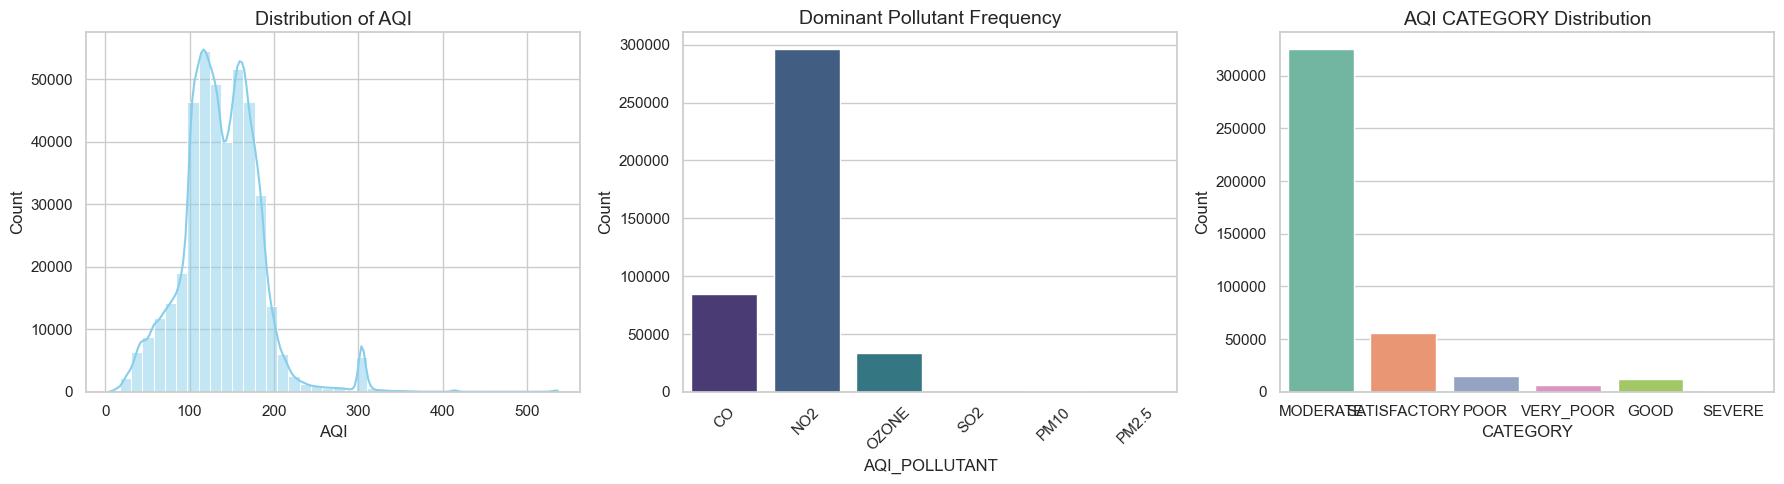

In [63]:
# Make a clean copy
df_plot = df_train.copy()

# Remove rows with NA in any of the 3 target columns
df_plot = df_plot.dropna(subset=["AQI", "AQI_POLLUTANT", "CATEGORY"])

plt.figure(figsize=(18, 5))

# ---------------------------------------
# Plot 1: AQI Distribution (Numeric)
# ---------------------------------------
plt.subplot(1, 3, 1)
sns.histplot(df_plot["AQI"], bins=40, kde=True, color="skyblue")
plt.title("Distribution of AQI", fontsize=14)
plt.xlabel("AQI")
plt.ylabel("Count")

# ---------------------------------------
# Plot 2: AQI_POLLUTANT (Categorical)
# ---------------------------------------
plt.subplot(1, 3, 2)
sns.countplot(x=df_plot["AQI_POLLUTANT"], palette="viridis")
plt.title("Dominant Pollutant Frequency", fontsize=14)
plt.xlabel("AQI_POLLUTANT")
plt.ylabel("Count")
plt.xticks(rotation=45)

# ---------------------------------------
# Plot 3: CATEGORY Distribution
# ---------------------------------------
plt.subplot(1, 3, 3)
sns.countplot(x=df_plot["CATEGORY"], palette="Set2")
plt.title("AQI CATEGORY Distribution", fontsize=14)
plt.xlabel("CATEGORY")
plt.ylabel("Count")
plt.xticks()

plt.tight_layout()
plt.show()


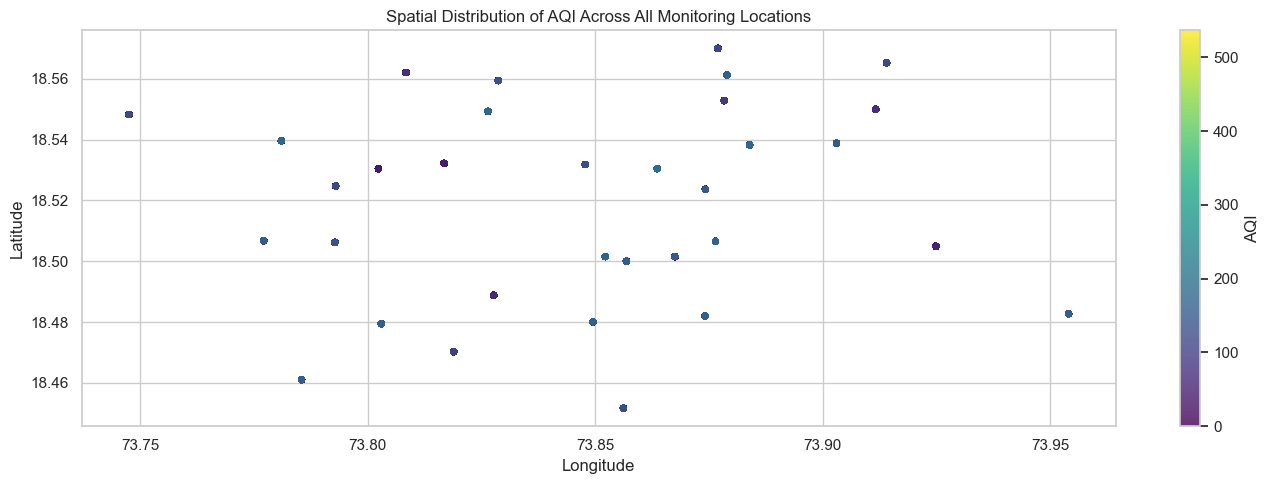

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Copy full training dataset
df_geo = df_train.copy()

# Remove any rows missing AQI or coordinates
df_geo = df_geo.dropna(subset=["AQI", "Lattitude", "Longitude"])

plt.figure(figsize=(14, 5))

plt.scatter(
    df_geo["Longitude"],
    df_geo["Lattitude"],
    c=df_geo["AQI"],
    cmap="viridis",
    s=25,
    alpha=0.8,
    edgecolor="none"
)

plt.colorbar(label="AQI")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of AQI Across All Monitoring Locations")

plt.tight_layout()
plt.show()



## 2. Data Preparation & Missing Values

### 2.1 Train/Test Files

- **Train**: `Participants_Dataset_Training_v1.csv`  
  - ~417,637 rows, 31 columns  
- **Test**: `Participants_Dataset_Test_v1.csv`  
  - ~103,205 rows, 28 columns  
  - No target columns: `AQI`, `AQI_POLLUTANT`, `CATEGORY`

### 2.2 Missing Value Strategy (Train)

1. **Initial diagnosis**  
   - Large number of missing values across many sensor columns (humidity, light, sound, temperature, UV, air pressure, some pollutants).  
   - Targets and location/time columns (`AQI`, `NAME`, `LASTUPDATEDATETIME`, `Lattitude`, `Longitude`) were complete.

2. **Cleaning categorical targets**
   - `CATEGORY` contained a spurious category: `"nullvalue"` → treated as **missing**.
   - `AQI_POLLUTANT` contained valid labels: `['CO', 'NO2', 'OZONE', 'SO2', 'PM10', 'PM2.5']`.
   - Any values outside the allowed sets were coerced to `NaN`.

3. **KNN-based imputation (train set)**  
   - Dropped `NAME` and `LASTUPDATEDATETIME` from the imputation step (to avoid non-numeric and non-stationary effects).
   - Categorical targets (`CATEGORY`, `AQI_POLLUTANT`) were:
     - Label-encoded to integers.
     - All features were scaled using `StandardScaler`.
     - **`KNNImputer(n_neighbors=7, weights="distance")`** was applied on the full numeric array.
     - After imputation, categorical columns were:
       - Rounded and clipped to valid integer ranges.
       - Inverse-transformed back to original string labels.
   - The final imputed dataframe is stored as **`df_clean_final`**, and the original `NAME` and `LASTUPDATEDATETIME` were added back.

4. **Distribution check (sanity check for imputation)**  
   - Compared **original vs cleaned** distributions for:
     - `AQI`
     - `AQI_POLLUTANT`
   - Histograms and KDE plots for `AQI` and bar charts for `AQI_POLLUTANT` showed that the **imputed dataset preserved the original shape reasonably well**, indicating that KNN imputation did not distort the data severely.

### 2.3 Missing Values in Test Set

For the **test dataset**:

- `df_test.isna().sum()` and row-wise checks showed some missing values.
- As per the exam instructions and for simplicity in deployment, the approach was:
  - **Drop rows with any missing values** (`df_test.dropna()`).
  - Convert `LIGHT` from string to float.
  - Convert `LASTUPDATEDATETIME` to datetime and derive an `hour` feature.
  - Drop `NAME` and `LASTUPDATEDATETIME` for modeling, keeping:
    - All pollutant readings
    - Environmental variables
    - Derived `hour`


In [7]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.impute import KNNImputer

# df = df_train.copy()
# df = df.drop(columns=["NAME", "LASTUPDATEDATETIME"])

# # STEP 1 : CLEAN CATEGORICAL COLUMNS
# df['CATEGORY'] = df['CATEGORY'].replace('nullvalue', np.nan)
# df['LIGHT'] = df['LIGHT'].replace('[]', np.nan)


# allowed_cat_category = ['MODERATE', 'SATISFACTORY', 'POOR', 'VERY_POOR', 'GOOD', 'SEVERE']
# df.loc[~df['CATEGORY'].isin(allowed_cat_category), 'CATEGORY'] = np.nan

# allowed_cat_pollutant = ['CO', 'NO2', 'OZONE', 'SO2', 'PM10', 'PM2.5']
# df.loc[~df['AQI_POLLUTANT'].isin(allowed_cat_pollutant), 'AQI_POLLUTANT'] = np.nan


# # STEP 2 : SAFE ENCODE CATEGORICAL COLUMNS
# cat_cols = ['CATEGORY', 'AQI_POLLUTANT']
# label_encoders = {}

# for col in cat_cols:
#     le = LabelEncoder()

#     # Fit only on non-null values
#     non_null = df[col].dropna().astype(str)
#     le.fit(non_null)

#     # Create encoded column filled with NaN
#     df[col] = df[col].astype(str)
#     df[col] = df[col].where(df[col] != "nan", np.nan)

#     # Encode only non-null rows
#     df.loc[df[col].notna(), col] = df.loc[df[col].notna(), col].apply(lambda x: le.transform([x])[0])

#     # Convert column to float (for KNN)
#     df[col] = df[col].astype(float)

#     label_encoders[col] = le

In [ ]:
# # STEP 3 : SCALE FEATURES
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(df)

# # STEP 4 : KNN IMPUTATION
# imputer = KNNImputer(n_neighbors=7, weights='distance')
# scaled_imputed = imputer.fit_transform(scaled_data)

# # STEP 5 : INVERSE SCALING
# df_imputed = pd.DataFrame(scaler.inverse_transform(scaled_imputed), columns=df.columns)

# # STEP 6 : DECODE CATEGORICAL COLUMNS SAFELY
# for col in cat_cols:
#     le = label_encoders[col]

#     # Round and clamp
#     df_imputed[col] = df_imputed[col].round().astype(int)
#     df_imputed[col] = df_imputed[col].clip(0, len(le.classes_) - 1)

#     df_imputed[col] = le.inverse_transform(df_imputed[col])

# # Final dataset
# df_clean_final = df_imputed.copy()
# # 75m 7.6s

# # Add dropped columns back
# df_clean_final["NAME"] = df_train["NAME"].values
# df_clean_final["LASTUPDATEDATETIME"] = df_train["LASTUPDATEDATETIME"].values

# df_clean_final_path = os.path.join(data_dir, "df_cleaned.csv")
# df_clean_final.to_csv(df_clean_final_path)

In [ ]:
df_clean_final_path = os.path.join(data_dir, "df_cleaned.csv")

df_clean_final =pd.read_csv(df_clean_final_path)
df_clean_final = df_clean_final.drop(columns=["Unnamed: 0"])
print("Shape of Imputed Data:",df_clean_final.shape)
df_clean_final.isna().sum().sum()
df_clean_final.head()

Shape of Imputed Data: (417637, 31)


,AQI,AQI_POLLUTANT,CATEGORY,HUMIDITY,LIGHT,NO_MAX,NO_MIN,NO2_MAX,NO2_MIN,OZONE_MAX,...,SOUND,TEMPRATURE_MAX,TEMPRATURE_MIN,UV_MAX,UV_MIN,AIR_PRESSURE,Lattitude,Longitude,NAME,LASTUPDATEDATETIME
0,117.71,CO,MODERATE,17.463,3366.120,0.0,0.0,60.0,40.0,13.0,...,85.321,42.0,24.0,2.1,0.1,0.931,18.538857,73.903019,ABC Farm House Junction_4,5/13/2019 12:16
1,121.84,NO2,MODERATE,21.642,1349.702,0.0,0.0,70.0,66.0,20.0,...,83.599,38.0,25.0,0.3,0.1,0.931,18.561238,73.878972,BRTS Visharant wadi_38,5/13/2019 12:16
2,108.11,NO2,MODERATE,21.131,2128.711,0.0,0.0,62.0,56.0,36.0,...,72.519,40.0,24.0,0.9,0.1,0.930,18.562059,73.808384,ChurchKhadakiRailwayStation_36,5/13/2019 12:16
3,134.01,NO2,MODERATE,17.926,840.325,0.0,0.0,77.0,75.0,21.0,...,75.843,42.0,24.0,2.8,0.1,0.927,18.506206,73.792772,Kothrud PMPML BusDepot_48,5/13/2019 12:16
4,142.61,NO2,MODERATE,19.240,2549.996,0.0,0.0,86.0,82.0,6.0,...,78.756,40.0,26.0,3.4,0.1,0.927,18.481994,73.874147,Market Yard Junction_2,5/13/2019 12:16


In [10]:
df = df_train.copy()

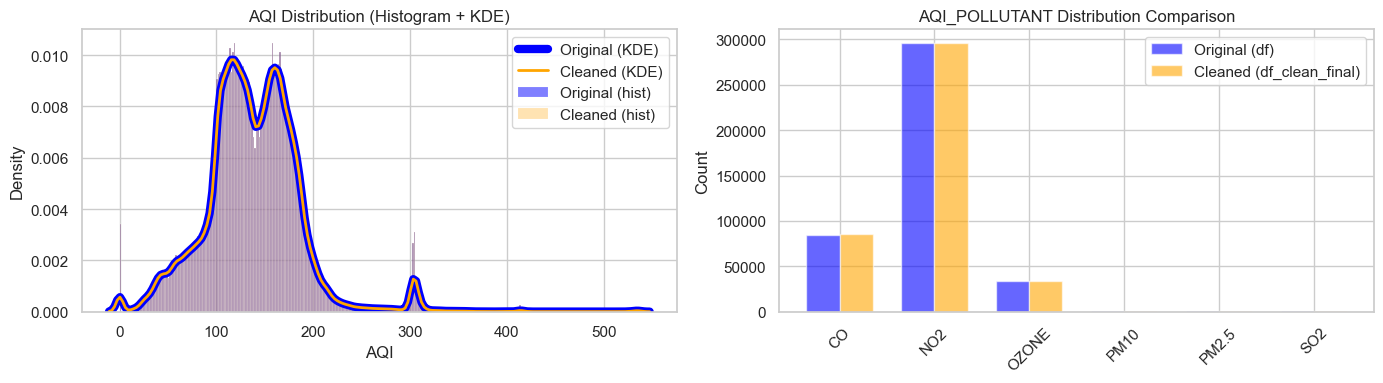

In [13]:
df_aqi = df["AQI"].dropna()
df_clean_aqi = df_clean_final["AQI"]
df_poll = df["AQI_POLLUTANT"].dropna()
df_clean_poll = df_clean_final["AQI_POLLUTANT"]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(df_aqi,    color="blue",   ax=axes[0], stat="density", alpha=0.5, label="Original (hist)")
sns.histplot(df_clean_aqi, color="orange", ax=axes[0], stat="density", alpha=0.3, label="Cleaned (hist)")
sns.kdeplot(df_aqi, label="Original (KDE)", color="blue", ax=axes[0], linewidth=6)
sns.kdeplot(df_clean_aqi, label="Cleaned (KDE)", color="orange", ax=axes[0], linewidth=2)

axes[0].set_title("AQI Distribution (Histogram + KDE)")
axes[0].set_xlabel("AQI")
axes[0].set_ylabel("Density")
axes[0].legend()


orig_counts = df_poll.value_counts().sort_index()
clean_counts = df_clean_poll.value_counts().sort_index()
pollutants = sorted(set(orig_counts.index).union(clean_counts.index))
x = np.arange(len(pollutants))
width = 0.35
axes[1].bar(x - width/2, orig_counts.reindex(pollutants, fill_value=0),
            width, label='Original (df)', color='blue', alpha=0.6)
axes[1].bar(x + width/2, clean_counts.reindex(pollutants, fill_value=0),
            width, label='Cleaned (df_clean_final)', color='orange', alpha=0.6)
axes[1].set_xticks(x)
axes[1].set_xticklabels(pollutants, rotation=45)
axes[1].set_title("AQI_POLLUTANT Distribution Comparison")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.tight_layout()
plt.show()

From plot, we can see that distribution before and after filling missing values are approximately same

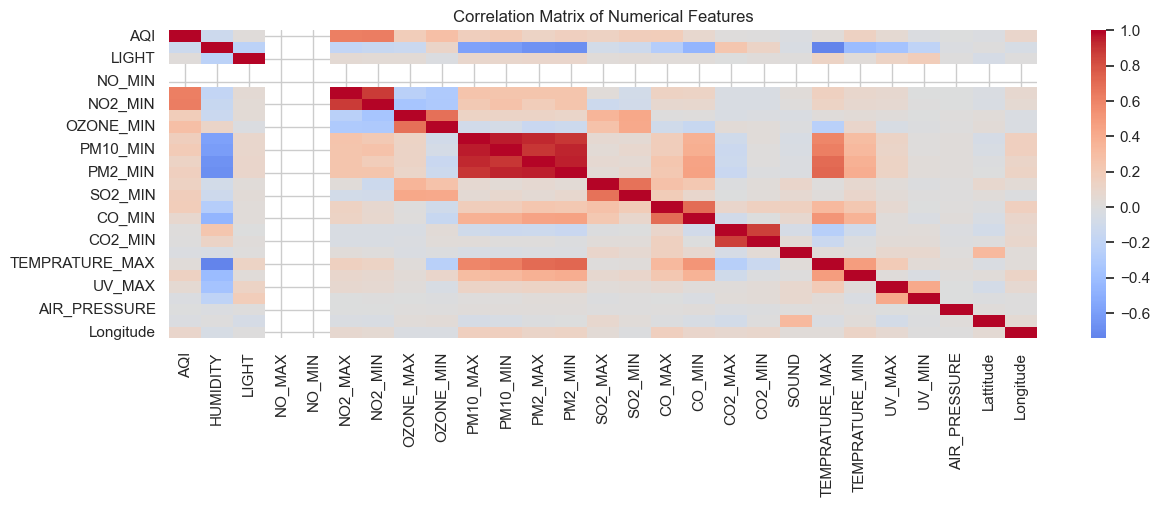

In [59]:
# Select only numerical columns
num_df = df_clean_final.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(14, 4))
sns.heatmap(num_df.corr(), cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [21]:
corr_matrix = num_df.corr().abs()

# Select upper triangle only
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Collect correlations above threshold
high_corr = [
    (col, row, upper.loc[row, col]) 
    for col in upper.columns 
    for row in upper.index 
    if upper.loc[row, col] > 0.5
]

# Convert to DataFrame and sort
df_high_corr = pd.DataFrame(high_corr, columns=['Feature1', 'Feature2', 'Correlation'])
df_high_corr = df_high_corr.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

df_high_corr


,Feature1,Feature2,Correlation
0,PM10_MIN,PM10_MAX,0.954149
1,PM2_MIN,PM2_MAX,0.945800
2,PM2_MIN,PM10_MIN,0.937560
3,PM2_MAX,PM10_MAX,0.926097
4,PM2_MIN,PM10_MAX,0.894783
5,PM2_MAX,PM10_MIN,0.884834
6,NO2_MIN,NO2_MAX,0.873688
7,CO2_MIN,CO2_MAX,0.861852
8,TEMPRATURE_MAX,HUMIDITY,0.741207
9,TEMPRATURE_MAX,PM2_MIN,0.718049


## Correlation Analysis (Identifying Correlated Observations)
1. **Correlation matrix**

   * Heatmap of `num_df.corr()` showed strong blocks of high correlation.

2. **Highly correlated pairs (|r| > 0.5)**
   The top correlated feature pairs included:

   * **Within pollutant min/max pairs:**

     * `PM10_MAX` ↔ `PM10_MIN`
     * `PM2_MAX` ↔ `PM2_MIN`
     * `NO2_MAX` ↔ `NO2_MIN`
     * `OZONE_MAX` ↔ `OZONE_MIN`
     * `SO2_MAX` ↔ `SO2_MIN`
     * `CO_MAX` ↔ `CO_MIN`
     * `CO2_MAX` ↔ `CO2_MIN`
   * Some cross-pollutant correlations (e.g. traffic-related pollutants rising together).

3. **Interpretation**

   * Many features come in **min–max pairs for the same pollutant**, naturally producing high correlation.
   * For tree-based models (Random Forest), this multicollinearity is not a major issue.
   * For linear models, one could drop one of each highly correlated pair (e.g. keep only `*_MAX` features) to reduce redundancy.


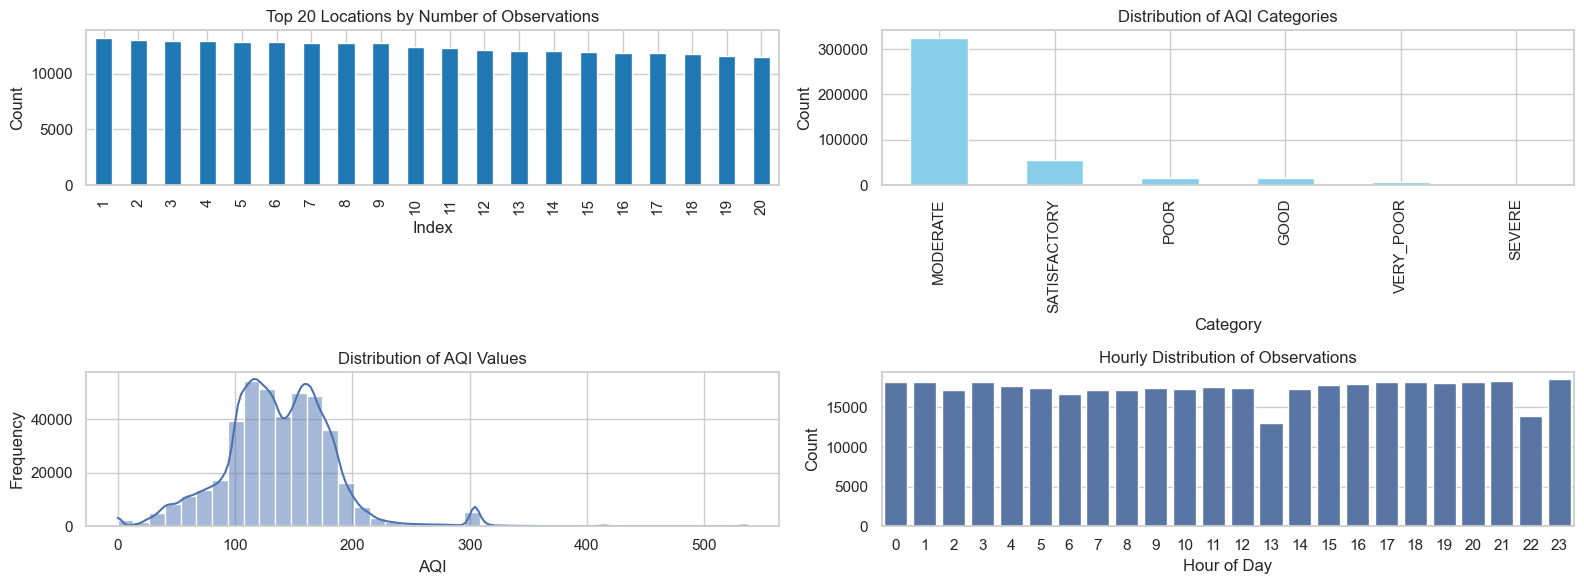

In [32]:
# Convert datetime if needed
df_clean_final["LASTUPDATEDATETIME"] = pd.to_datetime(df_clean_final["LASTUPDATEDATETIME"])
df_clean_final["hour"] = df_clean_final["LASTUPDATEDATETIME"].dt.hour

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 6))

# --- Plot 1: Locations with index instead of names ---
loc_counts = df_clean_final["NAME"].value_counts().head(20)
loc_counts.plot(kind='bar', ax=axes[0, 0], color='tab:blue')

axes[0, 0].set_title("Top 20 Locations by Number of Observations")
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("Count")

# Replace x-tick labels (location names) with 1..20 index numbers
axes[0, 0].set_xticklabels(range(1, 21))

# --- Plot 2: AQI Categories ---
df_clean_final["CATEGORY"].value_counts().plot(
    kind='bar', ax=axes[0, 1], color='skyblue'
)
axes[0, 1].set_title("Distribution of AQI Categories")
axes[0, 1].set_xlabel("Category")
axes[0, 1].set_ylabel("Count")

# --- Plot 3: AQI Distribution ---
sns.histplot(df_clean_final["AQI"], bins=40, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Distribution of AQI Values")
axes[1, 0].set_xlabel("AQI")
axes[1, 0].set_ylabel("Frequency")

# --- Plot 4: Hourly Distribution ---
sns.countplot(x="hour", data=df_clean_final, ax=axes[1, 1])
axes[1, 1].set_title("Hourly Distribution of Observations")
axes[1, 1].set_xlabel("Hour of Day")
axes[1, 1].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()


## Bias Analysis

Using `df_clean_final`, the following aspects were examined:

1. **Location bias (`NAME`)**

   * Bar plot of the **top 20 locations by number of observations** showed that:

     * Some stations have **many more readings** than others.
     * This means the model is somewhat **biased towards conditions at frequently measured locations**.

2. **Category imbalance (`CATEGORY`)**

   * Frequency plot of `CATEGORY` indicated that moderate and satisfactory conditions are **more common** than extreme categories such as `VERY_POOR` or `SEVERE`.
   * This can lead to:

     * Better performance in normal conditions.
     * Less experience (and potentially lower accuracy) in extreme pollution scenarios.

3. **AQI distribution**

   * Histogram of `AQI` shows a skewed distribution with a concentration in **low to mid AQI** values, and fewer extreme high AQI values.

4. **Temporal bias (`hour`)**

   * The count plot of `hour` suggested that:

     * Some hours of the day are **over-represented** (e.g., commuting times or regular measurement intervals).
     * This may bias the model towards certain temporal patterns and under-represent others.


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import joblib


# Start with cleaned dataframe
df = df_clean_final.copy()

# Convert LIGHT (object → float)
df["LIGHT"] = df["LIGHT"].astype(float)

# Drop unwanted columns
df = df.drop(columns=["NAME", "LASTUPDATEDATETIME"])


In [39]:
# Targets
y_AQI = df["AQI"]                        # regression
y_pollutant = df["AQI_POLLUTANT"]        # classification
y_category = df["CATEGORY"]              # classification

# Features for all models = everything except targets
X = df.drop(columns=["AQI", "AQI_POLLUTANT", "CATEGORY"])


In [40]:
X_train, X_test, yAQI_train, yAQI_test = train_test_split(
    X, y_AQI, test_size=0.2, random_state=42
)

_, _, yPoll_train, yPoll_test = train_test_split(
    X, y_pollutant, test_size=0.2, random_state=42
)

_, _, yCat_train, yCat_test = train_test_split(
    X, y_category, test_size=0.2, random_state=42
)


In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rf_reg = RandomForestRegressor(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, yAQI_train)

joblib.dump(rf_reg, "AQI_regressor_model.pkl")
# rf_reg = joblib.load("AQI_regressor_model.pkl")

pred_AQI = rf_reg.predict(X_test)
rmse_AQI = root_mean_squared_error(yAQI_test, pred_AQI)
print("RMSE for AQI Prediction:", rmse_AQI)


RMSE for AQI Prediction: 3.442032660409098


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_poll = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)

rf_poll.fit(X_train, yPoll_train)


joblib.dump(rf_poll, "AQI_pollutant_classifier.pkl")
# rf_poll = joblib.load("AQI_pollutant_classifier.pkl")

pred_pollutant = rf_poll.predict(X_test)
acc_pollutant = accuracy_score(yPoll_test, pred_pollutant)
print("Accuracy for AQI_POLLUTANT Prediction:", acc_pollutant)


Accuracy for AQI_POLLUTANT Prediction: 0.9923618427353702


In [49]:
rf_cat = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)

rf_cat.fit(X_train, yCat_train)

joblib.dump(rf_cat, "AQI_category_classifier.pkl")
# rf_cat = joblib.load("AQI_category_classifier.pkl")

pred_category = rf_cat.predict(X_test)
acc_category = accuracy_score(yCat_test, pred_category)
print("Accuracy for CATEGORY Prediction:", acc_category)


Accuracy for CATEGORY Prediction: 0.9905540657025189



## Key Drivers Influencing AQI

From the structure of the AQI definition and the trained Random Forest model (feature importances), the **main drivers** of AQI in this dataset are:

1. **Particulate Matter:**

   * `PM2_MAX`, `PM2_MIN` (PM₂.₅)
   * `PM10_MAX`, `PM10_MIN` (PM₁₀)
   * These are typically the **strongest contributors** and dominate AQI in urban India.

2. **Gaseous Pollutants:**

   * `NO2_MAX`, `NO2_MIN` (traffic emissions)
   * `OZONE_MAX`, `OZONE_MIN`
   * `SO2_MAX`, `SO2_MIN`
   * `CO_MAX`, `CO_MIN`

3. **Meteorological & Environmental Conditions:**

   * `HUMIDITY`, `TEMPRATURE_MAX/MIN`, `AIR_PRESSURE`, `UV_MAX/MIN`
   * These control **dispersion and accumulation** of pollutants.

4. **Time-of-day (`hour`):**

   * Captures traffic patterns (e.g., morning/evening peaks) and photochemical activity (ozone formation during daytime).

Together, these drivers explain most of the variance in AQI learned by the model.



## Rules That Can Be Used to Predict AQI (Model-Based Intuition)
### Question: `Devising a predictive model to predict the AQI for other Areas`

While the main model is a Random Forest (ensemble, non-linear), we can derive **approximate human-readable rules** aligned with the learned patterns:

1. **High particulate levels → High AQI**

   * If `PM2_MAX` and `PM10_MAX` are above their upper quantiles, the model predicts **high AQI values**, often corresponding to `POOR`/`VERY_POOR`/`SEVERE`.

2. **Moderate pollutants, normal meteorology → Moderate AQI**

   * When all major pollutants (PM₂.₅, PM₁₀, NO₂, O₃, SO₂, CO) sit in mid ranges and wind/dispersion is reasonable, AQI tends to fall into **`MODERATE` or `SATISFACTORY`**.

3. **Clean pollutant levels → Good AQI**

   * If all pollutants are well below thresholds, AQI is predicted as **`GOOD`**.

4. **Time-of-day effect**

   * Early morning and late evening (commuting hours) often show **higher AQI** due to traffic and low mixing heights.
   * Midday may show reduced AQI for some pollutants due to better mixing and dispersion.

These rules can be formalized, for example:

* If `PM2_MAX > T1` or `PM10_MAX > T2` → AQI ≥ 200
* If all pollutants < lower thresholds → AQI < 100

(Where `T1`, `T2` are thresholds derived from observed distribution or pollutant breakpoints.)

In [50]:
print("N/A values",df_test.isna().sum().sum())
print("\nN/A values in each column\n",df_test.isna().sum())
print("\nNumber of distinct entries per column:")
print(df_test.nunique())

# Number of rows that have at least one NA value
rows_with_na = df_test.isna().any(axis=1).sum()
print("Number of rows with at least one NA value:", rows_with_na)

N/A values 77913

N/A values in each column
 NAME                      0
HUMIDITY               5121
LIGHT                  6072
NO_MAX                    0
NO_MIN                    0
NO2_MAX                 577
NO2_MIN                 577
OZONE_MAX               608
OZONE_MIN               608
PM10_MAX               3233
PM10_MIN               3233
PM2_MAX                3233
PM2_MIN                3233
SO2_MAX                 837
SO2_MIN                 837
CO_MAX                  608
CO_MIN                  608
CO2_MAX                1565
CO2_MIN                1565
SOUND                  5120
TEMPRATURE_MAX         5061
TEMPRATURE_MIN         5061
UV_MAX                12518
UV_MIN                12518
AIR_PRESSURE           5120
LASTUPDATEDATETIME        0
Lattitude                 0
Longitude                 0
dtype: int64

Number of distinct entries per column:
NAME                     10
HUMIDITY              25693
LIGHT                 66174
NO_MAX                    1
NO_MIN

In [55]:
print("Raw Test Shape:", df_test.shape)

# Drop NA rows
df_test = df_test.dropna()
print("Shape After Dropping NA:", df_test.shape)

Raw Test Shape: (82689, 29)
Shape After Dropping NA: (82689, 29)


In [ ]:
df_test["LIGHT"] = df_test["LIGHT"].astype(float)
df_test["LASTUPDATEDATETIME"] = pd.to_datetime(df_test["LASTUPDATEDATETIME"], errors="coerce")
df_test["hour"] = df_test["LASTUPDATEDATETIME"].dt.hour
df_test_features = df_test.drop(columns=["NAME", "LASTUPDATEDATETIME"])

rf_reg = joblib.load("AQI_regressor_model.pkl")
rf_poll = joblib.load("AQI_pollutant_classifier.pkl")
rf_cat = joblib.load("AQI_category_classifier.pkl")
print("Models loaded successfully!")

# ALIGN COLUMNS WITH TRAINING COLUMNS
# Read training feature names (from model)
train_feature_names = rf_reg.feature_names_in_

# Add any missing columns with 0
for col in train_feature_names:
    if col not in df_test_features.columns:
        df_test_features[col] = 0

# Drop extra columns not used by model
df_test_features = df_test_features[train_feature_names]

Models loaded successfully!


In [ ]:
# PREDICTIONS

pred_AQI = rf_reg.predict(df_test_features)
pred_pollutant = rf_poll.predict(df_test_features)
pred_category = rf_cat.predict(df_test_features)

df_prediction = pd.DataFrame({
    "NAME": df_test["NAME"].values,
    "PRED_AQI": pred_AQI,
    "PRED_AQI_POLLUTANT": pred_pollutant,
    "PRED_CATEGORY": pred_category
})


output_path = os.path.join(data_dir, "Problem2_Prediction.csv")
df_prediction.to_csv(output_path, index=False)

print(f"\nPrediction file saved successfully at: {output_path}")
df_prediction.head()


Prediction file saved successfully at: Problem2_Prediction.csv


,NAME,PRED_AQI,PRED_AQI_POLLUTANT,PRED_CATEGORY
0,PMPML_Bus_Depot_Deccan_15,166.546533,NO2,MODERATE
1,Rajashri_Shahu_Bus_stand_19,102.581467,NO2,MODERATE
2,Hadapsar_Gadital_01,102.765867,OZONE,MODERATE
3,Dr Baba Saheb Ambedkar Sethu Junction_60,78.124533,NO2,SATISFACTORY
4,Lullanagar_Square_14,81.181800,NO2,SATISFACTORY



## Scalability Across the Country

### Question: `Make it scalable to be used across the country`

The entire pipeline is **designed to be scalable**:

1. **Model-independent of location names**

   * `NAME` is dropped from the feature set during training.
   * This ensures the model learns from **pollutant + meteorology patterns** and can be applied to **any new sensor location**.

2. **Standardized feature set**

   * As long as nationwide sensors report the same variables:

     * Pollutant min/max
     * Meteorological variables
     * Time-of-day
   * The same preprocessing + model pipeline can be reused.

3. **Reusable KNN imputation**

   * The KNN-based missing-values strategy is **generic** and can be applied to any region, provided similar feature scales and distributions.

4. **Deployment**

   * The use of serialized models (`.pkl` via `joblib`) allows:

     * Easy deployment as an API.
     * Integration into dashboards, city-level decision support tools, and nationwide systems.




## Using Predictions to Automate Actions to Improve Air Quality
### Question: `Use the predictions to automate the actions to improve the air quality`
Once AQI is predicted for each location and time, we can define **policy rules** based on AQI categories:

### Example action mapping:

* **GOOD (0–50)**

  * No action required; maintain current operations.
* **SATISFACTORY / MODERATE (51–200)**

  * Monitor sensitive groups.
  * Recommend limiting prolonged outdoor exertion for vulnerable populations.
* **POOR (201–300)**

  * Issue health advisories.
  * Encourage public transport, car-pooling.
  * Restrict open burning and dust-generating construction activities.
* **VERY POOR (301–400)**

  * Enforce stricter traffic controls in hotspots.
  * Temporarily halt major polluting construction.
  * Alert schools/hospitals and recommend staying indoors.
* **SEVERE (>400)**

  * Trigger emergency response plans.
  * Shut down major known pollution sources.
  * Issue stay-indoors advisory for the general population.

The **predicted AQI + CATEGORY** for each location thus serve as a **decision trigger** for:

* Dynamic traffic management
* Industrial regulation and operating hours
* Public health advisories and warnings
* Prioritization of inspection and mitigation efforts in worst-hit locations

## Summary

* **Missing values** were handled using **KNN imputation** on the training set and row-wise dropping on the test set.
* **Correlated observations** were identified via a correlation matrix and a high-correlation pair list, especially among pollutant min/max pairs.
* **Biases** in the data were examined by location, category, AQI distribution, and hour-of-day, revealing location and category imbalance.
* **Predictive models**:

  * `RandomForestRegressor` for AQI (RMSE ≈ 3.44 on validation set)
  * `RandomForestClassifier` for AQI_POLLUTANT and CATEGORY (good accuracy on held-out data).
* The pipeline is **scalable across the country** and supports **automated action planning** based on predicted AQI and its categories.

Overall, the solution delivers a complete, end-to-end AQI prediction workflow aligned with the exam requirements.
